# Autoreject and Spike Analysis

Here, we run autoreject on the final ICA preprocessed data and then perform Spike analysis.

In [2]:
# comment if you don't have nb_black installed
%load_ext lab_black

In [3]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys
from copy import copy, deepcopy

warnings.filterwarnings("ignore")

import mne
from mne import make_fixed_length_epochs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids
import autoreject
from autoreject import AutoReject, read_auto_reject

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
    LeaveOneGroupOut,
)
from sklearn.utils import resample
import sklearn
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.features import spike_feature_vector
from episcalp.io.read import load_persyst_spikes, load_reject_log
from episcalp.utils.utils import NumpyEncoder

# if you installed sporf via README
from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Data Directories

In [4]:
jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

# not ready yet
upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [5]:
jh_ica_root = jhroot / "derivatives" / "ICA" / "1-30Hz-30" / "win-20"
jeff_ica_root = jeffroot / "derivatives" / "ICA" / "1-30Hz-30" / "win-20"

In [6]:
# read in spike dataframe
jh_spike_dataset = load_persyst_spikes(jhroot)
jeff_spike_dataset = load_persyst_spikes(jeffroot)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
Loading data for subjects: ['jeff001', 'jeff002', 'jeff101', 'jeff102', 'jeff201', 'jeff202', 'jeff203', 'jeff20

In [7]:
display(jh_spike_dataset["data"][5])

,onset,duration,description,sample,ch_name,perception,height,n_secs
0,274.0,0.155,Spike O2-Av12 perception:0.61 height:92,54800,O2,0.61,92,1100.0
1,448.0,0.125,Spike P3-T34 perception:0.59 height:145,89600,P3,0.59,145,1100.0


# Load Previously Ran Autoreject and Filter Epochs

In [8]:
verbose = False

In [11]:
# reformat the channel spike dataframes based on autoreject logs
for dataset, deriv_root in zip(
    [jh_spike_dataset, jeff_spike_dataset], [jh_ica_root, jeff_ica_root]
):
    subjects = dataset["subject"]

    # loop through each dataset and preprocess the channel spike
    # dataframes based on the autoreject log
    for idx in range(len(subjects)):
        subject = subjects[idx]

        # get the channel spike df and bids path
        data = dataset["data"][idx]
        bids_path = dataset["bids_path"][idx]
        bids_path.update(root=deriv_root)

        if data.empty:
            if verbose:
                print(f"Skipping: {subject} with {bids_path}")
            continue

        # load in the reject log
        raw = read_raw_bids(bids_path)
        reject_log = load_reject_log(bids_path)

        # get spikes not in bad epochs
        bad_epochs = reject_log.bad_epochs
        bad_epoch_idx = np.argwhere(bad_epochs)
        n_secs = data["n_secs"][0]
        events = mne.make_fixed_length_events(
            raw, id=1, start=0, stop=None, duration=1.0, first_samp=True, overlap=0.0
        )
        assert len(events) == len(bad_epochs)

        # mark all spikes in bad epochs
        data["epoch_idx"] = None
        data["bad_epoch"] = None

        for jdx, sample in enumerate(data["sample"]):
            lower_idx = np.argwhere(sample <= events[:, 0])[0]
            higher_idx = np.argwhere(sample >= events[:, 0])[-1]
            epoch_idx = higher_idx[0]
            data["epoch_idx"][jdx] = epoch_idx
            in_bad_epoch = epoch_idx in bad_epoch_idx
            data["bad_epoch"][jdx] = in_bad_epoch

        # reset the new dataframe
        dataset["data"][idx] = data
    #     display(data)
    #     break

In [12]:
display(data.head())
print(subject)
print(dataset["bids_path"][idx])
print(sample)
print(raw)
print(len(data))
print(len(data[data["bad_epoch"] == True]))
# print(events)

,onset,duration,description,sample,ch_name,perception,height,n_secs,epoch_idx,bad_epoch
0,40.0,0.080,Spike T3-Av12 perception:0.26 height:66,20000,T3,0.26,66,1021.0,40,False
1,48.0,0.135,Spike T3-Av12 perception:0.31 height:80,24000,T3,0.31,80,1021.0,48,False
2,78.0,0.130,Spike T3-Av12 perception:0.15 height:68,39000,T3,0.15,68,1021.0,78,False
3,89.0,0.125,Spike T3-Av12 perception:0.4 height:59,44500,T3,0.4,59,1021.0,89,False
4,133.0,0.095,Spike T3-Av12 perception:0.11 height:83,66500,T3,0.11,83,1021.0,133,False


jeff210
/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/derivatives/ICA/1-30Hz-30/win-20/sub-jeff210/ses-1/eeg/sub-jeff210_ses-1_run-1_eeg.edf
479000
<RawEDF | sub-jeff210_ses-1_run-1_eeg.edf, 14 x 510500 (1021.0 s), ~20 kB, data not loaded>
61
0


# Create Feature Matrix from Spikes

In [13]:
# now compute spike features depending on if they're in bad
# epochs or not
dataset = deepcopy(jh_spike_dataset)
for key, item in jeff_spike_dataset.items():
    dataset[key].extend(deepcopy(item))

In [135]:
perception_thresh = 0.5

In [136]:
# Now, let's remove all spikes with bad epochs
for idx in range(len(dataset["subject"])):
    ch_spike_df = dataset["data"][idx]

    if ch_spike_df.empty:
        continue

    # only keep rows with bad epochs
    ch_spike_df = ch_spike_df[ch_spike_df["bad_epoch"] == False]
    ch_spike_df["perception"] = pd.to_numeric(ch_spike_df["perception"])
    ch_spike_df = ch_spike_df[ch_spike_df["perception"] >= perception_thresh]
    dataset["data"][idx] = ch_spike_df

In [137]:
spike_features = []
for idx in range(len(dataset["subject"])):
    ch_spike_df = dataset["data"][idx]
    ch_names = dataset["ch_names"][idx]
    spike_feature_vec = spike_feature_vector(ch_spike_df, ch_names)
    spike_features.append(spike_feature_vec)

spike_features = np.array(spike_features)

print(spike_features.shape)

(125, 6)


In [138]:
X = spike_features.copy()

# Perform Validation Experiment

In [139]:
meta_df = pd.DataFrame()
for root in [jhroot, jeffroot]:
    df = pd.read_csv(os.path.join(root, "participants.tsv"), sep="\t")
    meta_df = pd.concat((meta_df, df), axis=0)

# meta_df = pd.concat(df_list, axis=0)

display(meta_df.head())

,participant_id,age,sex,hand,site,exp_condition,outcome,num_aeds,final_diagnosis,epilepsy_type,epilepsy_hemisphere,epilepsy_lobe,orig_sub_id
0,sub-jhh001,NaN,NaN,NaN,None,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
1,sub-jhh002,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
2,sub-jhh003,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,0.0,PNES,NaN,NaN,NaN,NaN
3,sub-jhh004,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN
4,sub-jhh005,NaN,NaN,NaN,BV,non-epilepsy-normal-eeg,0,1.0,PNES,NaN,NaN,NaN,NaN


In [140]:
print(dataset.keys())
# get the y-labels
subjects = np.array(dataset["subject"])
roots = dataset["roots"]

exp_conditions = []
for subject, root in zip(subjects, roots):
    subj_df = meta_df[meta_df["participant_id"] == f"sub-{subject}"]
    exp_condition = subj_df["exp_condition"].values[0]
    exp_conditions.append(exp_condition)
print(np.unique(exp_conditions))

dict_keys(['data', 'subject', 'bids_path', 'ch_names', 'roots'])
['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [141]:
exp_conditions = np.array(exp_conditions)
normal_idx = [idx for idx, cond in enumerate(exp_conditions) if "-normal-" in cond]
# exp_conditions[
exp_conditions[normal_idx] = "normal-eeg"
print(np.unique(exp_conditions))

['epilepsy-abnormal-eeg' 'normal-eeg']


In [142]:
y_enc = LabelEncoder()
y_enc = LabelBinarizer()

In [143]:
y = y_enc.fit_transform(exp_conditions)
y_classes = y_enc.classes_
print(y_enc.classes_)
print(y.shape)

['epilepsy-abnormal-eeg' 'normal-eeg']
(125, 1)


In [144]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [145]:
cv = StratifiedGroupKFold(
    n_splits=n_splits,
    random_state=random_state,
    shuffle=True,
)
cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)

# cv = LeaveOneGroupOut()
# cv = BootstrapSplit(n_splits=100, random_state=random_state)

## Define Classification Models

In [146]:
random_state = 12345
clf_name = "sporf"
# clf_name = 'rf'
clf_name = "lr"
max_features = X.shape[1]

rf_model_params = {
    "n_estimators": 1000,
    "max_features": max_features,
    "n_jobs": -1,
    "random_state": random_state,
}
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state,
    #                    "penalty": "l2"
}

In [147]:
if clf_name == "rf":
    clf = RandomForestClassifier(**rf_model_params)
elif clf_name == "sporf":
    # only used if you installed cysporf
    clf = ObliqueForestClassifier(**rf_model_params)
elif clf_name == "lr":
    clf = LogisticRegression(**lr_model_params)

# for multiclass
# clf = OneVsRestClassifier(clf)

clf = make_pipeline(
    #     StandardScaler(),
    clf
)
print(clf)
print(clf.steps)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=12345))])
[('logisticregression', LogisticRegression(n_jobs=-1, random_state=12345))]


In [148]:
scoring_funcs = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "cohen_kappa_score": make_scorer(cohen_kappa_score),
    "roc_auc": "roc_auc",  # roc_auc_score,
    "f1": "f1",  # f1_score,
    "recall": "recall",  # makerecall_score,
    "precision": "precision",  # precision_score,
    "jaccard": "jaccard",  # jaccard_score,
    "average_precision": "average_precision",  # average_precision_score,
    "neg_brier_score": "neg_brier_score",  # brier_score_loss,
}

# define multiclass cross_validation scoring metrics
f1_micro = lambda x: make_scorer(f1_score, average="micro")
recall_micro = lambda x: make_scorer(recall_score, average="micro")
precision_micro = lambda x: make_scorer(precision_score, average="micro")
jaccard_micro = lambda x: make_scorer(jaccard_score, average="micro")
roc_ovr = lambda x: make_scorer(roc_auc_score, multi_class="ovr")

# some scorers need to get defined with this for multiclass
def cohen_scorer(clf, X, y):
    y_pred = clf.predict(X).argmax(axis=1)
    y = y.argmax(axis=1)
    return cohen_kappa_score(y, y_pred)


def balanced_accuracy_scorer(clf, X, y):
    y_pred = clf.predict(X).argmax(axis=1)
    y = y.argmax(axis=1)
    return balanced_accuracy_score(y, y_pred)


multiclass_scoring_funcs = {
    "balanced_accuracy": balanced_accuracy_scorer,
    "cohen_kappa_score": cohen_scorer,
    "roc_auc_ovr": "roc_auc_ovr",  # roc_ovr,
    "f1_micro": "f1_micro",  # f1_micro,
    "recall_micro": "recall_micro",
    "precision_micro": "precision_micro",
    "jaccard_micro": "jaccard_micro",
}

if len(np.unique(y_classes)) == 2:
    scoring = scoring_funcs
else:
    scoring = multiclass_scoring_funcs

print(scoring)

{'balanced_accuracy': make_scorer(balanced_accuracy_score), 'cohen_kappa_score': make_scorer(cohen_kappa_score), 'roc_auc': 'roc_auc', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'jaccard': 'jaccard', 'average_precision': 'average_precision', 'neg_brier_score': 'neg_brier_score'}


In [149]:
# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=subjects,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    return_train_score=True,
    n_jobs=-1,
    error_score="raise",
)

# get the estimators
estimators = scores.pop("estimator")

In [150]:
print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_y_pred_proba",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
    "test_y",
    "test_y_encodings",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]

    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_y"].append(y[test_inds])
    #     scores["test_y_encodings"].append(y_encode[test_inds])

    # evaluate on the train set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    y_pred_prob = estimator.predict_proba(X_train)
    y_pred_label = np.argmax(y_pred_prob, axis=1)

    # compute calibration curve
    if len(np.unique(y_classes)) == 2:
        if y_pred_prob.ndim == 2:
            y_pred_prob = y_pred_prob[:, -1]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_train, y_pred_prob, n_bins=10, strategy="quantile"
        )
        scores["train_fraction_pos"].append(fraction_of_positives)
        scores["train_mean_pred_value"].append(mean_predicted_value)

    # append training data
    scores["train_y_pred_proba"].append(y_pred_prob)

    # store ROC curve metrics on the held-out test set
    if len(np.unique(y_classes)) == 2:
        fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_train, y_pred_prob, pos_label=0)
        scores["train_fpr"].append(fpr)
        scores["train_tpr"].append(tpr)
        scores["train_fnr"].append(fnr)
        scores["train_tnr"].append(tnr)
        scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)
    y_pred_label = np.argmax(y_pred_prob, axis=1)

    # compute calibration curve
    if len(np.unique(y_classes)) == 2:
        if y_pred_prob.ndim == 2:
            y_pred_prob = y_pred_prob[:, -1]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_pred_prob, n_bins=10, strategy="quantile"
        )
        scores["test_fraction_pos"].append(fraction_of_positives)
        scores["test_mean_pred_value"].append(mean_predicted_value)

    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob)

    # store ROC curve metrics on the held-out test set
    if len(np.unique(y_classes)) == 2:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
        scores["test_fpr"].append(fpr)
        scores["test_tpr"].append(tpr)
        scores["test_fnr"].append(fnr)
        scores["test_tnr"].append(tnr)
        scores["test_thresholds"].append(thresholds)

    if y_test.ndim == 2:
        y_test_ = y_test.astype(int).argmax(axis=1)
    else:
        y_test_ = y_test.astype(int)
    conf_matrix = confusion_matrix(y_test_, (y_pred_label).astype(int))
    if len(np.unique(y_classes)) == 2:
        tn, fp, fn, tp = conf_matrix.ravel()
        scores["test_specificity"].append(tn / (tn + fp))

    # get the permutation importances
    r = permutation_importance(
        estimator,
        X_test,
        y_test,
        n_repeats=5,
        random_state=random_state,
        n_jobs=-1,
        scoring="roc_auc_ovr",
    )
    scores["test_importances"].append(r.importances)

Using estimator  Pipeline(steps=[('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=12345))])


In [151]:
# add metadata
scores["y_classes"] = y_classes

## Save Model Output Scores

In [152]:
exp_name = "spike_with_autoreject"

In [153]:
fname = (
    deriv_root.parent
    / "derivatives"
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_{exp_name}_withstd.json"
)
print(fname)

/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/derivatives/ICA/1-30Hz-30/derivatives/cv20_lr_mtry6_spike_with_autoreject_withstd.json


In [154]:
# with open(fname.with_suffix(".json"), "w") as fp:
#     json.dump(scores, fp, cls=NumpyEncoder)

# Run Basic Model Plotting

In [155]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_cohen_kappa_score', 'train_cohen_kappa_score', 'test_roc_auc', 'train_roc_auc', 'test_f1', 'train_f1', 'test_recall', 'train_recall', 'test_precision', 'train_precision', 'test_jaccard', 'train_jaccard', 'test_average_precision', 'train_average_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_fraction_pos', 'train_mean_pred_value', 'train_y_pred_proba', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_subjects', 'test_subjects', 'test_y_pred_proba', 'test_importances', 'test_specificity', 'test_y', 'test_y_encodings', 'y_classes'])


## ROC Curves

In [156]:
def _interp_roc(fpr, tpr):
    mean_fpr = np.linspace(0, 1, 100)

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return interp_tpr, mean_fpr

In [157]:
# either train or test set
which_set = "test"

# construct mean/std ROC curves
tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

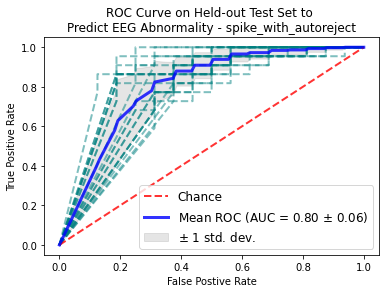

/Users/adam2392/Documents/scikit-learn/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adam2392/Documents/scikit-learn/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adam2392/Documents/scikit-learn/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adam2392/Documents/scikit-learn/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [158]:
which_set = "test"
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set to \nPredict EEG Abnormality - {exp_name}",
    xlabel="False Postive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
# fig.savefig(figure_dir / f"roc_curve_{exp_name}.pdf", bbox_inches="tight")